<a href="https://colab.research.google.com/github/MahdiTheGreat/Semantic-Segmentation-with-Deep-Learning/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
!pip install rasterio
import rasterio as rio
from rasterio.transform import xy
import os
import random
!pip install ipdb
import ipdb
!pip install torchinfo
from torchinfo import summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00


In [2]:
import subprocess
import sys
import torch

def install_pytorch(torchvision=True, torchaudio=False,cuda_version="cu118"):
    package = ["torch"]

    if torchvision:
     package.append("torchvision")

    if torchaudio:
     package.append("torchaudio")

    package.append("--index-url")

    if torch.cuda.is_available():
        print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")
        print("Installing PyTorch with CUDA support...")
        package.append("https://download.pytorch.org/whl/"+cuda_version)

    else:
        print("CUDA is not available. Installing CPU version of PyTorch...")
        package.append("https://download.pytorch.org/whl/cpu")

    subprocess.check_call([sys.executable, "-m", "pip", "install"] + package) # Concatenate lists to form the command

if __name__ == "__main__":
    install_pytorch()

CUDA is not available. Installing CPU version of PyTorch...


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(f'Using device: {device}')

Using device: cpu


In [4]:
# Set random seed for reproducibility
def set_seed(seed=2024):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(2024)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random
from torch.utils.data import DataLoader

In [8]:

file_id = "1ODRghvcRWp9WabC34dh11Cd0iHw0bamJ"
output_file = "downloaded_file.zip"

!gdown --id $file_id -O $output_file

print(f"File {output_file} downloaded successfully!")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ODRghvcRWp9WabC34dh11Cd0iHw0bamJ
From (redirected): https://drive.google.com/uc?id=1ODRghvcRWp9WabC34dh11Cd0iHw0bamJ&confirm=t&uuid=4945dd37-7ee0-4b1c-9c35-e89185df5700
To: /content/downloaded_file.zip
100% 4.93G/4.93G [01:15<00:00, 65.3MB/s]
File downloaded_file.zip downloaded successfully!


In [9]:
# Create a folder to extract the files
extract_path = "/content/extracted_files"
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
!unzip -q "$output_file" -d "$extract_path"

print(f"File extracted to {extract_path}")


File extracted to /content/extracted_files


In [10]:
PathToGeoTiffFile = extract_path+'/Potsdam-GeoTif'

Text(0.5, 1.0, 'Input image')

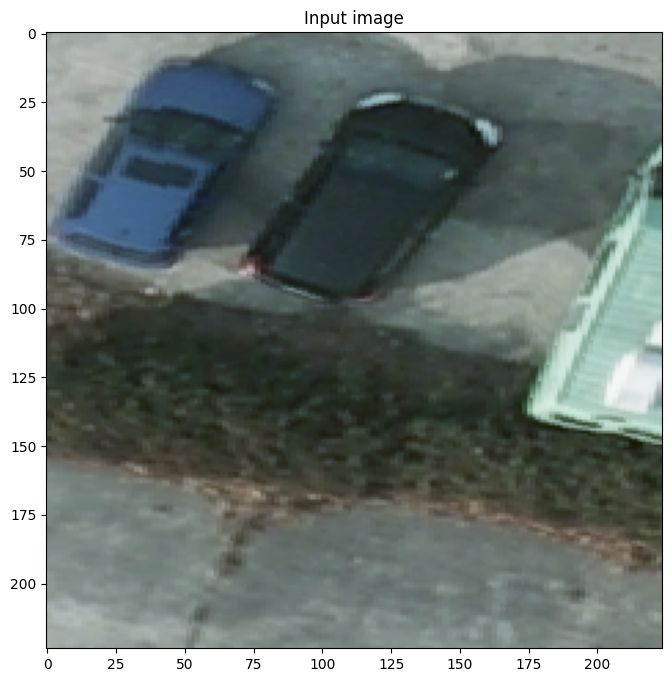

In [11]:
blob = PathToGeoTiffFile +  '/0000000224-0000042784.tif'
img = rio.open(blob)
img_array = img.read()
imtransform = img.transform
nRows = img_array.shape[1]
ncols = img_array.shape[2]
Bands = img_array.shape[0]

img_array = img_array.reshape(Bands, nRows*ncols).T
img_array = img_array.reshape( nRows,ncols, Bands)

plt.figure(figsize=(24,8))

plt.imshow(img_array[:,:,0:3]/255)
plt.title('Input image')

In [12]:
from rasterio.transform import xy

with rio.open(blob) as dataset:
    width, height = dataset.width, dataset.height
    print("width: ",width)
    print("height: ",height)
    center_x = width // 2
    center_y = height // 2
    lon, lat = xy(dataset.transform, center_y, center_x)

print(f"Center Longitude: {lon}, Center Latitude: {lat}")


width:  224
height:  224
Center Longitude: 13.050771384662005, Center Latitude: 52.411034522559454


In [31]:
import os
import torch
import rasterio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class GeoTiffDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        with rasterio.open(img_path) as src:
            image = src.read()  # (Bands, Height, Width)

        # Normalize to [0,1] range (for 16-bit TIFFs)
        image = image.astype(np.float32) / np.max(image)

        # Split features (X) and labels (y)
        X = image[:4, :, :]  # First 4 bands (Red, Green, Blue, IR)
        y = image[5, :, :]   # 6th band (Segmentation mask or labels)

        # Apply transformations (only to X)
        if self.transform:
            X = self.transform(X)

        # Convert X back to (C, H, W) and y to tensor
        X = torch.tensor(X) #.permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        y = torch.tensor(y, dtype=torch.long)  # Convert labels to tensor

        return X, y  # Return (inputs, labels)

# Define transformations for input images
# Normalzing is a good idea as it
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x)), # Convert to tensor using Lambda
    transforms.Normalize(mean=[0.5] * 4, std=[0.5] * 4)  # Normalize 4 bands
])

# Load Dataset
dataset = GeoTiffDataset(PathToGeoTiffFile, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
input_shape=None
# Example: Iterate through DataLoader
for X_batch, y_batch in dataloader:
    input_shape=X_batch.shape
    print(X_batch.shape, y_batch.shape)
    # Expected output: (16, 5, 224, 224) for inputs, (16, 224, 224) for labels
    break

<ipython-input-31-b150fa557046>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X) #.permute(2, 0, 1)  # (H, W, C) → (C, H, W)


torch.Size([16, 4, 224, 224]) torch.Size([16, 224, 224])


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN architecture
class CNN(nn.Module):
    def __init__(self, input_shape, filter_sizes, kernel_size=3, conv_factor=1, pool_size=2, pool_stride=2,
                 conv_layer=nn.Conv2d, pool_layer=nn.MaxPool2d, activation_layer=nn.ReLU,
                 padding_mode='zeros', padding=1, flatten=False):
        super(CNN, self).__init__()

        output_shape = None
        conv_block = None
        self.blocks = nn.ModuleList()
        self.hook_handles=[]

        def hook_fn(module, input, output):
            print(f"{module.__class__.__name__}: {output.shape}")

        for i in range(len(filter_sizes)):
            for j in range(conv_factor):
                if i == 0 and j == 0:
                    conv_block = nn.Sequential(
                        conv_layer(input_shape[1], filter_sizes[i], kernel_size=kernel_size,
                                   padding=padding, padding_mode=padding_mode),
                        activation_layer()
                    )
                    dummy_input = torch.randn(input_shape)
                    output_shape = conv_block(dummy_input).shape
                else:
                    conv_block = nn.Sequential(
                        conv_layer(output_shape[1], filter_sizes[i], kernel_size=kernel_size,
                                   padding=padding, padding_mode=padding_mode),
                        activation_layer()
                    )
                    dummy_input = torch.randn(output_shape)
                    output_shape = conv_block(dummy_input).shape

                conv_block.add_module(str(len(conv_block)), pool_layer(kernel_size=pool_size, stride=pool_stride))

            self.blocks.append(conv_block)

        if flatten:
            self.blocks.append(nn.Flatten())

        # Register hooks
        for block in self.blocks:
            for layer in block.children():
                self.hook_handles.append(layer.register_forward_hook(hook_fn))

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    def unhook(self):

     # Now after you're done inspecting, remove all the hooks
     for hook in self.hook_handles:
         hook.remove()




filter_sizes = [32, 6, 1]

# Create model and move to device
cnn_model = CNN(input_shape=input_shape, filter_sizes=filter_sizes, pool_layer=nn.Identity).to(device)

# Test forward pass
cnn_model(torch.randn(input_shape).to(device))
cnn_model.unhook()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, weight_decay=0.0005)


Conv2d: torch.Size([16, 32, 224, 224])
ReLU: torch.Size([16, 32, 224, 224])
Identity: torch.Size([16, 32, 224, 224])
Conv2d: torch.Size([16, 6, 224, 224])
ReLU: torch.Size([16, 6, 224, 224])
Identity: torch.Size([16, 6, 224, 224])
Conv2d: torch.Size([16, 1, 224, 224])
ReLU: torch.Size([16, 1, 224, 224])
Identity: torch.Size([16, 1, 224, 224])


In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
patience = 5  # For early stopping
num_epochs = 20
batch_size = 100
save_path_p4 = 'best_cnn_model.pth'

# Helper function as the training loop
def train_model(model,
                train_loader,
                test_loader,
                criterion,
                optimizer,
                device,
                num_epochs,
                patience,
                save_path,
                verbose=True):
    # Initialize tracking variables
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    best_val_acc = 0.0
    epochs_no_improve = 0

    if test_loader is None:
        test_loader = train_loader
        test_size = len(train_loader.dataset)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss and correct predictions
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_acc_history.append(val_acc)

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, '
                  f'Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        # Early Stopping Check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            if verbose:
                print(f'Validation accuracy improved to {best_val_acc:.2f}%. Model saved to {save_path}')
        else:
            epochs_no_improve += 1

            if epochs_no_improve >= patience:
                if verbose:
                    print("Early stopping triggered!")
                break

    return train_acc_history, val_acc_history, train_loss_history

train_ratio=0.8
# Define the sizes for each subset (80% train, 10% val, 10% test)
train_size = int(train_ratio* len(dataset))
val_size = int((1-train_ratio)/2 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure total sum is 100%

# Split the dataset into train, val, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for each subset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example: Iterate through the training DataLoader
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break  # Remove this line to iterate through the whole dataset


train_acc_history, val_acc_history, train_loss_history = train_model(
    model=cnn_model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    patience=patience,
    save_path=save_path_p4,
    verbose=True
)

In [ ]:
# Load Best Model
model.load_state_dict(torch.load('best_cnn_model.pth'))

In [ ]:
# Helper function to plot the training metrics
def plot_training_metrics(train_acc, val_acc, train_loss, title, save_path):
    # Ensure that all input lists have the same length
    assert len(train_acc) == len(val_acc) == len(train_loss), "All input histories must have the same length."

    epochs = range(1, len(train_acc) + 1)

    # Create the metrics DataFrame
    df_metrics = pd.DataFrame({
        'Epoch': epochs,
        'Training Accuracy (%)': train_acc,
        'Validation Accuracy (%)': val_acc,
        'Training Loss': train_loss
    })

    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Training and Validation Accuracy on ax1
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color=color)
    ax1.plot(df_metrics['Epoch'], df_metrics['Training Accuracy (%)'], label='Train Acc', color='tab:blue')
    ax1.plot(df_metrics['Epoch'], df_metrics['Validation Accuracy (%)'], label='Val Acc', color='tab:cyan')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for Training Loss
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Loss', color=color)
    ax2.plot(df_metrics['Epoch'], df_metrics['Training Loss'], label='Train Loss', color='tab:red')
    ax2.tick_params(axis='y', labelcolor=color)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    # Set plot title and layout
    plt.title(title)
    plt.tight_layout()

    # Save and display the plot
    plt.savefig(save_path)
    plt.show()

# Combined plot
plot_training_metrics(
    train_acc=train_acc_history,
    val_acc=val_acc_history,
    train_loss=train_loss_history,
    title='Training and validation metrics (Problem 4)',
    save_path='training_validation_metrics_cnn.pdf'
)

In [ ]:
# Helper function to evaluate the performance of the model
def evaluate_model(model, test_loader, device, verbose=True):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_acc = 100 * correct / total
    if verbose:
        print(f'\nFinal Test Accuracy: {final_acc:.2f}%')

    return final_acc

# Final evaluation
final_acc_p4 = evaluate_model(
    model=cnn_model,
    test_loader=test_loader,
    device=device,
    verbose=True
)

# Save the trained model
torch.save(model.state_dict(), 'cnn_model_final.pth')
print("Trained model saved as 'cnn_model_final.pth'")